In [1]:
from reprophylo import *

Remove redundancy by clustering the 12S sequences with vsearch.

In [2]:
!vsearch -threads 5 --cluster_fast ../fetch_clean_align/12S_AmphibAlign.fasta --strand both --uc 12S_id-1.uc --id 1 --query_cov 1

vsearch v1.1.0_linux_x86_64, 31.3GB RAM, 8 cores
https://github.com/torognes/vsearch

Reading file ../fetch_clean_align/12S_AmphibAlign.fasta 0%

Fatal error: illegal character '-' on line 2 in the database file


In [4]:
pj=Project('../fetch_clean_align/target_locus.csv', pickle='new.pkl', git=False)

DEBUG:Cloud:Log file (/root/.picloud/cloud.log) opened


In [5]:
#pj = unpickle_pj('new.pkl', git=False)

The next code cell reads the GenBank file containing the reference sequences into memory. DO NOT RUN MORE THAN ONCE. Otherwise you must remove the pickle that has already been created.

In [5]:
pj.read_embl_genbank(['../fetch_and_clean/amphib12S_cropped_500bp.gb'])

/home/reprophylo/reprophylo.py:1015: UserWarning: Version control off
  warnings.warn('Version control off')


In [6]:
pj.extract_by_locus()

Distribution Of Sequence Lengths
Distribution Of Sequence Statistic "Gc_Content"


/usr/lib/pymodules/python2.7/matplotlib/figure.py:371: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


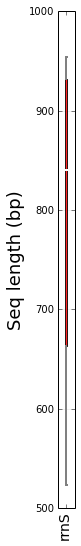

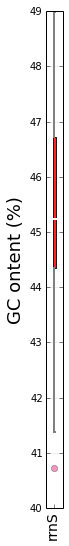

In [7]:
%matplotlib inline
pj.report_seq_stats()

In [8]:
species=[]
for r in pj.records:
    source = [f for f in r.features if f.type == 'source'][0]
    species.append(" ".join(source.qualifiers['organism'][0].split()[0:2]))
    
#print set(species)
total=len(species)
species=list(set(species))

print "Total number of records: %i" %total
print "Number of species (see below for full list): %i" %len(species)
print species

Total number of records: 90
Number of species (see below for full list): 18
['Alytes obstetricans', 'Pelophylax ridibundus', 'Triturus cristatus', 'Epidalea calamita', 'Rana catesbeiana', 'Salamandra salamandra', 'Discoglossus pictus', 'Hyla arborea', 'Bufo bufo', 'Xenopus laevis', 'Pelophylax esculentus', 'Lissotriton vulgaris', 'Bombina bombina', 'Pelophylax lessonae', 'Triturus carnifex', 'Rana temporaria', 'Ichthyosaura alpestris', 'Bombina variegata']


Extract ids of representative sequences identified by vsearch -> remove all others from the object.

NB: 'rrnS' must be used as this is the default loci name for 12S rRNA.

In [9]:
ids = []
recs_to_keep = {}
recs_to_drop = {}


uc=open('12S_500bp_id-1.uc', 'r')

for line in uc:
    if line.startswith('C'):
        ids.append(line.split("\t")[8])
        
recs_to_keep = {'rrnS': ids}
recs_to_drop = {'rrnS': []}

for r in pj.records:
    if not r.id in recs_to_keep['rrnS']:
        recs_to_drop['rrnS'].append(r.id)
        
print "to drop: %s" %len(recs_to_drop['rrnS'])
print "to keep: %s" %len(recs_to_keep['rrnS'])

print "TOTAL: %s" %(len(recs_to_drop['rrnS']) + len(recs_to_keep['rrnS']))

to drop: 30
to keep: 60
TOTAL: 90


Exclude redundant records from object.

In [10]:
pj.exclude(start_from_max=False, **recs_to_drop)

In [11]:
species=[]
for r in pj.records:
    if r.id in recs_to_keep['rrnS']:
        source = [f for f in r.features if f.type == 'source'][0]
        species.append(" ".join(source.qualifiers['organism'][0].split()[0:2]))
    
#print set(species)
total=len(species)
species=list(set(species))

print "Total number of records: %i" %total
print "Number of species (see below for full list): %i" %len(species)
print species

Total number of records: 60
Number of species (see below for full list): 18
['Alytes obstetricans', 'Pelophylax ridibundus', 'Pelophylax lessonae', 'Epidalea calamita', 'Rana catesbeiana', 'Salamandra salamandra', 'Triturus cristatus', 'Discoglossus pictus', 'Hyla arborea', 'Bufo bufo', 'Xenopus laevis', 'Pelophylax esculentus', 'Lissotriton vulgaris', 'Bombina bombina', 'Triturus carnifex', 'Rana temporaria', 'Ichthyosaura alpestris', 'Bombina variegata']


Write full Genbank records to file for later processing with SATIVA.

In [12]:
seqs = []
from Bio import SeqIO
for r in pj.records:
    if r.id in recs_to_keep['rrnS']:
        seqs.append(r)

out = open('12S_500_pre_Sativa.gb','w')
SeqIO.write(seqs, out, 'genbank')
out.close()

Configure Alignment.

In [13]:
rRNA = ["rrnS"]

muscle = AlnConf(pj, loci=rRNA,
                 method_name='muscleDefault', 
                 program_name='muscle')

muscle -in 832571474456826.89_rrnS.fasta


Perform alignment.

In [14]:
pj.align([muscle])

In [15]:
pj.alignments.keys()

['rrnS@muscleDefault']

In [16]:
print pj.used_methods['muscleDefault']

AlnConf named muscleDefault with ID 832571474456826.89
Loci: rrnS 
Created on: Wed Sep 21 11:20:26 2016
Commands:
rrnS: muscle -in 832571474456826.89_rrnS.fasta

Environment:
Platform: Linux-4.4.0-38-generic-x86_64-with-Ubuntu-14.04-trusty
 Processor: x86_64
 Python build: defaultMar 22 2014 22:59:56
 Python compiler: GCC 4.8.2
 Python implementation: CPython
 Python version: 2.7.6
 ete2 version: 2.2.1072
 biopython version: 1.68
 dendropy version: 3.12.2
 cloud version: 2.8.5
 reprophylo version 1.3
 User: biopc4
 Program and version: MUSCLE v3.8.31\nPal2Nal v14
 Program reference:\nEdgar 2004: MUSCLE: multiple sequence alignment with high accuracy and high throughput. Nucleic Acids Research 32(5):1792-1797\nMikita Suyama
 David Torrents
 and Peer Bork (2006) PAL2NAL: robust conversion of protein sequence alignments into the corresponding codon alignments.Nucleic Acids Res. 34
 W609-W612.
execution time:
7.93936300278


Core Methods section sentence:
The dataset(s) rrnS were first ali

In [17]:
pickle_pj(pj, '500.pkl')

'500.pkl'

In [18]:
pj.write_alns(id=['record_id','source_organism'], format='fasta')

['rrnS@muscleDefault_aln.fasta']

Alignment needs fair amount of trimming and several gaps within sequences. The below cell contains a custom solution for start/end-clipping the alignment.

We only want to trim the alignment from the end because this is the alignment that should be used for phylogenetic placement and it needs to be possible to align reads to the alignment.

Clipping positions are determined from start/end of the alignment by assessing the average per column completeness across 10 bp sliding windows. per column completeness is the proportion of sequences represented by ACGT in a given column. Average completeness is assessed across 10bp sliding windows.

The clipping point is defined as the position at which the alignment, starting from the 5'/3'-ends, respectively, retained an average completeness > 0.7 (i.e. 70% of the sequences are informative) for 10 consecutive sliding windows.


In [19]:
import numpy as np

per_col=[]

aln = pj.fa('rrnS@muscleDefault')


icol=0
for a in aln[1,:]:
    ACGT_count=0
    col=aln[:,icol]
    for i in range(len(col)):
        if col[i] in ['A','G','C','T']:
            ACGT_count+=1
#    print pj.fa('rrnS@muscle_defaults)[:,a]
    per_col.append(float(ACGT_count)/len(col))
    icol+=1

wsize=10
min_prop=0.7
    
print "\nFinding forward clip position:\n"
forw_count=0
forw_clip=0
for i in range(len(per_col)-wsize):
        
    if np.mean(per_col[i:i+10]) > min_prop:
        forw_count+=1
        forw_clip=i
        print forw_count,i,np.mean(per_col[i:i+wsize])
    else:
        forw_count=0
        
    if forw_count >= wsize:
        break
        
print "Suggested forward clip at: %s (%s,%s)" %(forw_clip-wsize,forw_count,forw_clip)

print "\nFinding reverse clip position:\n"
reve_count=0
reve_clip=0
for i in reversed(range(len(per_col)-wsize)):
        
    if np.mean(per_col[i:i+10]) > min_prop:
        reve_count+=1
        reve_clip=i
        print reve_count,i,np.mean(per_col[i:i+wsize])
    else:
        reve_count=0
        
    if reve_count >= wsize:
        break
    
print "Suggested reverse clip at: %s (%s,%s)" %(reve_clip+wsize,reve_count,reve_clip)

returning alignment object rrnS@muscleDefault

Finding forward clip position:

1 145 0.716666666667
2 146 0.733333333333
3 147 0.75
4 148 0.766666666667
5 149 0.783333333333
6 150 0.8
7 151 0.816666666667
8 152 0.816666666667
9 153 0.8
10 154 0.783333333333
Suggested forward clip at: 144 (10,154)

Finding reverse clip position:

1 982 0.711666666667
2 981 0.778333333333
3 980 0.84
4 979 0.901666666667
5 978 0.93
6 977 0.956666666667
7 976 0.966666666667
8 975 0.966666666667
9 974 0.966666666667
10 973 0.966666666667
Suggested reverse clip at: 983 (10,973)


Clip the alignment at the positions determined above and write to file. We'll use Biopython functions to do this.

Clip alignment - the new Biopython alignment object is called clipped_aln.

In [20]:
from Bio import AlignIO

aln = pj.fa('rrnS@muscleDefault')

clipped_aln = aln[:,forw_clip-wsize:reve_clip+wsize]

returning alignment object rrnS@muscleDefault


Convert the clipped alignment (which is a Biopython alignment object) to a ReproPhylo trimmed alignment object, so that we can resume working with it in ReproPhylo.

In [21]:
pj.trimmed_alignments["rrnS@muscleDefault_aln_clipped_500bp"] = clipped_aln

In [22]:
pj.trimmed_alignments

{'rrnS@muscleDefault_aln_clipped_500bp': <<class 'Bio.Align.MultipleSeqAlignment'> instance (60 records of length 839, SingleLetterAlphabet()) at 7fd7a4f57590>}

Write clipped alignment to file for downstream taxonomic curation using SATIVA.

In [23]:
from Bio import AlignIO

out=open('rrnS@muscleDefault_aln_clipped_500bp.phy', 'w')
AlignIO.write(clipped_aln, out, 'phylip-relaxed')
out.close()

How to run SATIVA is described in a different notebook. It may be a good strategy to set this going now in a separate notebook. Then contnue onwards in this notebook.

Infer Maximum Likelihood tree based on the clipped alignment. We are going to use RAxML.

Configure RAxML.

In [24]:
raxml = RaxmlConf(pj, method_name='raxml-muscleDefault-clipped',
                  program_name='raxmlHPC-PTHREADS-SSE3',
                  keepfiles=True,
                  cmd='raxmlHPC-PTHREADS-SSE3',
                  preset='fa',
                  alns=['rrnS@muscleDefault_aln_clipped_500bp'],
                  model='GAMMA',
                  threads=5,
                  cline_args={'-#': 100})

raxmlHPC-PTHREADS-SSE3 -f a -m GTRGAMMA -n 398211474456904.99_rrnS@muscleDefault_aln_clipped_500bp0 -p 883 -s 398211474456904.99_rrnS@muscleDefault_aln_clipped_500bp.fasta -T 5 -x 696 -N 100


In [25]:
pj.tree([raxml])

In [26]:
print pj.used_methods['raxml-muscleDefault-clipped']

RaxmlConf named raxml-muscleDefault-clipped with ID 398211474456904.99
Alignments: rrnS@muscleDefault_aln_clipped_500bp 
Created on: Wed Sep 21 11:21:44 2016
Commands:
rrnS@muscleDefault_aln_clipped_500bp:
raxmlHPC-PTHREADS-SSE3 -f a -m GTRGAMMA -n 398211474456904.99_rrnS@muscleDefault_aln_clipped_500bp0 -p 883 -s 398211474456904.99_rrnS@muscleDefault_aln_clipped_500bp.fasta -T 5 -x 696 -N 100

Environment:
Platform: Linux-4.4.0-38-generic-x86_64-with-Ubuntu-14.04-trusty
 Processor: x86_64
 Python build: defaultMar 22 2014 22:59:56
 Python compiler: GCC 4.8.2
 Python implementation: CPython
 Python version: 2.7.6
 ete2 version: 2.2.1072
 biopython version: 1.68
 dendropy version: 3.12.2
 cloud version: 2.8.5
 reprophylo version 1.3
 User: biopc4
 Program and version: raxmlHPC-PTHREADS-SSE3RAxML version 8.0.12
 Program reference: A. Stamatakis: RAxML Version 8: A tool for Phylogenetic Analysis and Post-Analysis of Large Phylogenies. In Bioinformatics
 2014.
execution time:
113.423015833

In [27]:
pickle_pj(pj, '500.pkl')

'500.pkl'

Now let's visualize the tree.

Prepare tree annotation:

 - define outgroups
 - specify support coloration


In [28]:
pj.add_qualifier_from_source('organism')

In [29]:
for species in ['Xenopus','Hyla']:
    pj.if_this_then_that(species, 'organism', 'outgroup', 'outgroup',
                         mode='part')

In [30]:
supports = {'black': [100,95],
            'dimgray': [95,75],
            'silver': [75,50]}

In [31]:
pj.clear_tree_annotations()
pj.annotate('.', 'outgroup', 'outgroup', 
            ['source_organism', 'record_id'], 
            node_support_dict=supports, multifurc=10,
            html='muscleDefault-clipped-500bp-raxml.html')

Check tree out. Have a think which sequences you would consider mislabelled and should better be removed from the reference database.

Create a static copy of the tree (the last *.png with the expected alignment id) for later

In [32]:
%%bash

last_png=$(ls -hlrt *rrnS@muscleDefault_aln_clipped_500bp.png | tail -n 1 | perl -ne 'chomp; @a=split(" "); print "$a[-1]"')
cp $last_png rrnS_muscleDefault_clipped_500bp_raxml.png

Now compare the Muscle alignment with Mafft alignment.

Configure Mafft alignment.

In [33]:
mafft_linsi = AlnConf(pj,                              # The Project
                      method_name='mafftLinsi',        # Any unique method name,
                      CDSAlign=False,                   # Specify as false as 12S rRNA is not recognised as a CDS
                      codontable=0,                    # The genetic code that
                      program_name='mafft',            # mafft or muscle.
                      cmd='mafft',                     # The command on your machine
                      loci=['rrnS'],                   # A list of loci names to align.vel.
                      cline_args={'localpair': True,   # Program specific keywords and arguments.
                                  'maxiterate': 1000}  # cine_args=={} by default, which will
                     )

mafft --localpair --maxiterate 1000 267641474457297.81_rrnS.fasta


Perform alignment.

In [34]:
pj.align([mafft_linsi])

In [35]:
print pj.used_methods['mafftLinsi']

AlnConf named mafftLinsi with ID 267641474457297.81
Loci: rrnS 
Created on: Wed Sep 21 11:28:17 2016
Commands:
rrnS: mafft --localpair --maxiterate 1000 267641474457297.81_rrnS.fasta

Environment:
Platform: Linux-4.4.0-38-generic-x86_64-with-Ubuntu-14.04-trusty
 Processor: x86_64
 Python build: defaultMar 22 2014 22:59:56
 Python compiler: GCC 4.8.2
 Python implementation: CPython
 Python version: 2.7.6
 ete2 version: 2.2.1072
 biopython version: 1.68
 dendropy version: 3.12.2
 cloud version: 2.8.5
 reprophylo version 1.3
 User: biopc4
 Program and version: MAFFT v7.123b
 Program reference:Katoh
 Standley 2013 (Molecular Biology and Evolution 30:772-780) MAFFT multiple sequence alignment software version 7: improvements in performance and usability.
execution time:
12.1976089478


Core Methods section sentence:
The dataset(s) rrnS were aligned using the program MAFFT v7.123b [1].

Reference:
Katoh, Standley 2013 (Molecular Biology and Evolution 30:772-780) MAFFT multiple sequence align

In [36]:
pickle_pj(pj, '500.pkl')

'500.pkl'

In [37]:
pj.write_alns(id=['record_id','source_organism'], format='fasta')

['rrnS@mafftLinsi_aln.fasta', 'rrnS@muscleDefault_aln.fasta']

Start/end-clip the alignment.

In [38]:
import numpy as np

per_col=[]

aln = pj.fa('rrnS@mafftLinsi')


icol=0
for a in aln[1,:]:
    ACGT_count=0
    col=aln[:,icol]
    for i in range(len(col)):
        if col[i] in ['A','G','C','T']:
            ACGT_count+=1
#    print pj.fa('rrnS@mafftDefault')[:,a]
    per_col.append(float(ACGT_count)/len(col))
    icol+=1

wsize=10
min_prop=0.7
    
print "\nFinding forward clip position:\n"
forw_count=0
forw_clip=0
for i in range(len(per_col)-wsize):
        
    if np.mean(per_col[i:i+10]) > min_prop:
        forw_count+=1
        forw_clip=i
        print forw_count,i,np.mean(per_col[i:i+wsize])
    else:
        forw_count=0
        
    if forw_count >= wsize:
        break
        
print "Suggested forward clip at: %s (%s,%s)" %(forw_clip-wsize,forw_count,forw_clip)

print "\nFinding reverse clip position:\n"
reve_count=0
reve_clip=0
for i in reversed(range(len(per_col)-wsize)):
        
    if np.mean(per_col[i:i+10]) > min_prop:
        reve_count+=1
        reve_clip=i
        print reve_count,i,np.mean(per_col[i:i+wsize])
    else:
        reve_count=0
        
    if reve_count >= wsize:
        break
    
print "Suggested reverse clip at: %s (%s,%s)" %(reve_clip+wsize,reve_count,reve_clip)

returning alignment object rrnS@mafftLinsi

Finding forward clip position:

Suggested forward clip at: -10 (0,0)

Finding reverse clip position:

Suggested reverse clip at: 10 (0,0)


In [39]:
from Bio import AlignIO

aln = pj.fa('rrnS@mafftLinsi')

clipped_aln = aln[:,forw_clip-wsize:reve_clip+wsize]

returning alignment object rrnS@mafftLinsi


Convert the clipped alignment (which is a Biopython alignment object) to a ReproPhylo trimmed alignment object, so that we can resume working with it in ReproPhylo.

In [40]:
pj.trimmed_alignments["rrnS@mafftLinsi_aln_clipped_500bp"] = clipped_aln

In [41]:
pj.trimmed_alignments

{'rrnS@mafftLinsi_aln_clipped_500bp': <<class 'Bio.Align.MultipleSeqAlignment'> instance (60 records of length 0, SingleLetterAlphabet()) at 7fd7a5250850>,
 'rrnS@muscleDefault_aln_clipped_500bp': <<class 'Bio.Align.MultipleSeqAlignment'> instance (60 records of length 839, SingleLetterAlphabet()) at 7fd7a4f57590>}

Write clipped alignment to file for downstream taxonomic curation using SATIVA.

In [42]:
from Bio import AlignIO

out=open('rrnS@mafftLinsi_aln_clipped_500bp.phy', 'w')
AlignIO.write(clipped_aln, out, 'phylip-relaxed')
out.close()

ValueError: Non-empty sequences are required

Infer Maximum Likelihood tree based on the clipped alignment. We are going to use RAxML.

Configure RAxML.

In [78]:
raxml = RaxmlConf(pj, method_name='raxml-mafftLinsi-clipped', 
                  program_name='raxmlHPC-PTHREADS-SSE3',
                  keepfiles=True,
                  cmd='raxmlHPC-PTHREADS-SSE3',
                  preset='fa',
                  alns=['rrnS@mafftLinsi_aln_clipped'],
                  model='GAMMA',
                  threads=5,
                  cline_args={'-#': 100})

raxmlHPC-PTHREADS-SSE3 -f a -m GTRGAMMA -n 257301474389474.4_rrnS@mafftLinsi_aln_clipped0 -p 291 -s 257301474389474.4_rrnS@mafftLinsi_aln_clipped.fasta -T 5 -x 655 -N 100


Run RAxML.

In [79]:
pj.tree([raxml])

ApplicationError: Non-zero return code 255 from 'raxmlHPC-PTHREADS-SSE3 -f a -m GTRGAMMA -n 257301474389474.4_rrnS@mafftLinsi_aln_clipped0 -p 291 -s 257301474389474.4_rrnS@mafftLinsi_aln_clipped.fasta -T 5 -x 655 -N 100'

In [80]:
print pj.used_methods['raxml-mafftLinsi-clipped']

KeyError: 'raxml-mafftLinsi-clipped'

In [ ]:
pickle_pj(pj, 'nr.pkl')

Now let's visualize the tree constructed from the mafft alignment.

Prepare tree annotation:

 -   define outgroups
 -   specify support coloration

In [ ]:
pj.add_qualifier_from_source('organism')

In [ ]:
for species in ['Xenopus','Hyla']:
    pj.if_this_then_that(species, 'organism', 'outgroup', 'outgroup',
                         mode='part')

In [ ]:
supports = {'black': [100,95],
            'dimgray': [95,75],
            'silver': [75,50]}

In [ ]:
pj.clear_tree_annotations()
pj.annotate('.', 'outgroup', 'outgroup', 
            ['source_organism', 'record_id'], 
            node_support_dict=supports, multifurc=10,
            html='mafftLinsi-clipped-raxml.html')

Check tree out and compare to the tree constructed from the muscle alignment.

Create a static copy of the tree (the last *.png with the expected alignment id for later.

In [ ]:
%%bash

last_png=$(ls -hlrt *CytB@mafftLinsi_aln_clipped.png | tail -n 1 | perl -ne 'chomp; @a=split(" "); print "$a[-1]"')
cp $last_png rrnS_mafftLinsi_clipped_raxml.png

In the meantime we have run SATIVA on the alignment that was the basis of the above tree.

Now we are going to highlight the records that SATIVA considers mislabelled in the tree. We are also going to add a heatmap to the tree illustrating the confidence that SATIVA has in a given call.

Parse SATIVA output and record putatively mislabelled sequence records and the confidence of the call.


In [ ]:
rec_mislabelled = {}
sativa=open('../3-SATIVA/CytB.mis', 'r')

for line in sativa:
    if not line.startswith(";"):
        rec_mislabelled[line.split("\t")[0]] = line.split("\t")[4]

Add two new qualifiers containing info about he SATIVA results to the sequence features.

In [ ]:
for r in pj.records:
    if r.id in rec_mislabelled:
        for f in r.features:
            f.qualifiers['mislabeled'] = ['yes']
            f.qualifiers['mislabeled_conf'] = [rec_mislabelled[r.id]]
    else:
        for f in r.features:
            f.qualifiers['mislabeled'] = ['no']
            f.qualifiers['mislabeled_conf'] = [0.0001]

In [ ]:
pj.propagate_metadata()

Prepare tree annotation:

  - color records that were identified by SATIVA as being mislabelled.
  - add heatmap with mislabel confidence

In [ ]:
leaf_colors = {'yes':'red', 'no': 'black'}
bg_colors = {'yes':'red', 'no': 'white'}

In [ ]:
pj.clear_tree_annotations()
pj.annotate('.', 'outgroup', 'outgroup', 
            ['source_organism', 'record_id'], 
            node_support_dict=supports, multifurc=10,
            html='muscleDefault-clipped-raxml-SATIVA.html',
            fsize=13,
            heat_map_meta = ['mislabeled_conf'], heat_map_colour_scheme = 1,
            leaf_node_color_meta = 'mislabeled', leaf_label_colors = leaf_colors)

In [ ]:
%%bash

last_png=$(ls -hlrt *rrnS@muscleDefault_aln_clipped.png | tail -n 1 | perl -ne 'chomp; @a=split(" "); print "$a[-1]"')
cp $last_png rrnS_muscleDefault_clipped_raxml_SATIVA_leaf_colored.png

In [ ]:
pj.clear_tree_annotations()
pj.annotate('.', 'outgroup', 'outgroup', 
            ['source_organism', 'record_id'], 
            node_support_dict=supports, multifurc=10,
            html='muscleDefault-clipped-raxml-SATIVA.html',
            fsize=13,
            heat_map_meta = ['mislabeled_conf'], heat_map_colour_scheme = 1,
            node_bg_meta = 'mislabeled', node_bg_color = bg_colors)

In [ ]:
%%bash

target=rrnS_muscleDefault_clipped_raxml_SATIVA_bg_colored.png

last_png=$(ls -hlrt *rrnS@muscleDefault_aln_clipped.png | tail -n 1 | perl -ne 'chomp; @a=split(" "); print "$a[-1]"')
cp $last_png $target

Have a look!

In [42]:
pickle_pj(pj, 'nr.pkl')

'nr.pkl'